# This Notebook will help to get started with the Elasticsearch connector

In [150]:
import sys
import requests
import pandas as pd
import datetime
import json

In [151]:
print('Last run:', datetime.datetime.utcnow(), 'UTC')  # timezone can't be detected from browser

Last run: 2018-03-15 11:06:40.346603 UTC


In [152]:
# make sure ES is up and running
res = requests.get('http://elasticsearch:9200')
r=json.loads(res.content)
r

{'cluster_name': 'il.es.cluster',
 'cluster_uuid': 'sBgbgyRXTvKta2cEJCczKQ',
 'name': 'e2714bb18e54',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2018-02-16T19:01:30.685723Z',
  'build_hash': '10b1edd',
  'build_snapshot': False,
  'lucene_version': '7.2.1',
  'minimum_index_compatibility_version': '5.0.0',
  'minimum_wire_compatibility_version': '5.6.0',
  'number': '6.2.2'}}

In [153]:
%%sh
# pip install elasticsearch
# already installed

In [154]:
# connect to our cluster
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'elasticsearch', 'port': 9200}])
es

<Elasticsearch([{'host': 'elasticsearch', 'port': 9200}])>

In [155]:
# Empty search to ensure it is working
res = es.search()
print(res["_shards"])
# res["hits"]["hits"][-1]


{'total': 486, 'successful': 486, 'skipped': 0, 'failed': 0}


Display our indices and document types saved in elasticsearch.

In [1]:
# the prefix "!" is the similar to "%%sh"-magic, but only valid in one line
!curl -XGET 'http://elasticsearch:9200/_cat/health?v'

epoch      timestamp cluster       status node.total node.data shards pri relo init unassign pending_tasks max_task_wait_time active_shards_percent
1521722931 12:48:51  il.es.cluster yellow          1         1     10  10    0    0       10             0                  -                 50.0%


In [2]:
# every index is green if it's healthy
!curl -XGET 'http://elasticsearch:9200/_cat/indices?v'

health status index              uuid                   pri rep docs.count docs.deleted store.size pri.store.size
yellow open   data-2018.03.22    AplqsHc4TGygOLI2XqTc1w   5   1       4622            0        1mb            1mb
yellow open   logging-2018.03.22 9uUXJVdtTDO1BoOg1n16uQ   5   1          6            0     36.8kb         36.8kb


In [157]:
!curl -XGET 'http://elasticsearch:9200/logstash-2018.03.01/_mapping?pretty=true'

{
  "logstash-2018.03.01" : {
    "mappings" : {
      "_default_" : {
        "dynamic_templates" : [
          {
            "message_field" : {
              "path_match" : "message",
              "match_mapping_type" : "string",
              "mapping" : {
                "norms" : false,
                "type" : "text"
              }
            }
          },
          {
            "string_fields" : {
              "match" : "*",
              "match_mapping_type" : "string",
              "mapping" : {
                "fields" : {
                  "keyword" : {
                    "ignore_above" : 256,
                    "type" : "keyword"
                  }
                },
                "norms" : false,
                "type" : "text"
              }
            }
          }
        ],
        "properties" : {
          "@timestamp" : {
            "type" : "date"
          },
          "@version" : {
            "type" : "keyword"
          },
          "geoip" : {

In [158]:
import subprocess
output = subprocess.check_output('curl -s -XGET "http://elasticsearch:9200/_all/_mapping"', shell=True)
output = json.loads(output)

indices = list(output.keys())
indices = [[index, typ] for index in indices for typ in output.get(index).get("mappings")]
list(indices)

[['logstash-2017.12.26', 'doc'],
 ['logstash-2017.12.26', '_default_'],
 ['logstash-2017.12.27', 'doc'],
 ['logstash-2017.12.27', '_default_'],
 ['logstash-2018.01.30', 'doc'],
 ['logstash-2018.01.30', '_default_'],
 ['logstash-2018.02.26', 'doc'],
 ['logstash-2018.02.26', '_default_'],
 ['logstash-2017.12.08', 'logstash'],
 ['logstash-2017.12.08', '_default_'],
 ['logstash-2017.12.19', 'doc'],
 ['logstash-2017.12.19', '_default_'],
 ['logstash-2017.12.05', 'logstash'],
 ['logstash-2017.12.05', '_default_'],
 ['logstash-2018.02.01', 'doc'],
 ['logstash-2018.02.01', '_default_'],
 ['logstash-2017.12.06', 'logstash'],
 ['logstash-2017.12.06', '_default_'],
 ['logstash-2017.11.30', 'logstash'],
 ['logstash-2017.11.30', '_default_'],
 ['logstash-2017.11.22', 'logstash'],
 ['logstash-2017.11.22', '_default_'],
 ['logstash-2018.01.23', 'doc'],
 ['logstash-2018.01.23', '_default_'],
 ['logstash-2018.01.20', 'doc'],
 ['logstash-2018.01.20', '_default_'],
 ['logstash-2017.12.21', 'doc'],
 ['log

In [108]:
# Problems with finding the document type for a given index pattern
#res = es.get(index="logstash-2018.02.07", id=1)
#print(res['_source'])


In [14]:
help(es.search)

Help on method search in module elasticsearch.client:

search(index=None, doc_type=None, body=None, params=None) method of elasticsearch.client.Elasticsearch instance
    Execute a search query and get back search hits that match the query.
    `<http://www.elastic.co/guide/en/elasticsearch/reference/current/search-search.html>`_
    
    :arg index: A comma-separated list of index names to search; use `_all`
        or empty string to perform the operation on all indices
    :arg doc_type: A comma-separated list of document types to search; leave
        empty to perform the operation on all types
    :arg body: The search definition using the Query DSL
    :arg _source: True or false to return the _source field or not, or a
        list of fields to return
    :arg _source_exclude: A list of fields to exclude from the returned
        _source field
    :arg _source_include: A list of fields to extract and return from the
        _source field
    :arg allow_no_indices: Whether to ign

In [144]:
# The results of metric testdata from the last 1 hour
body = {
  "size": 10,
  "query": {
    "bool": {
      "must": [
        {"range" : {
            "phenomenonTime" : {
                #"gte": "2018-02-20T09:08:34.230693+00:00", 
                "gte": "now-7d",
                "lte": "now", 
                "time_zone": "+01:00"
            }
        }},
        {"match": {
            "Datastream.name.keyword": {
                "query": "Airquality DS"
              }
        }}
      ]
    }
  }
}
res = es.search(index="logs*", body=body)
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("Timestamp: {}, \tmetric: {}, \tresult: {}\n".format(hit["_source"]["phenomenonTime"], 
            hit["_source"]["Datastream"]["name"], hit["_source"]["result"]))

Got 42416 Hits:
Timestamp: 2018-03-09T11:38:52+00:00, 	metric: Airquality DS, 	result: 1018

Timestamp: 2018-03-09T11:35:52+00:00, 	metric: Airquality DS, 	result: 1005

Timestamp: 2018-03-09T11:36:26+00:00, 	metric: Airquality DS, 	result: 1018

Timestamp: 2018-03-09T11:39:15+00:00, 	metric: Airquality DS, 	result: 1019

Timestamp: 2018-03-09T11:35:07+00:00, 	metric: Airquality DS, 	result: 1026

Timestamp: 2018-03-09T11:32:41+00:00, 	metric: Airquality DS, 	result: 1003

Timestamp: 2018-03-09T11:33:38+00:00, 	metric: Airquality DS, 	result: 1006

Timestamp: 2018-03-09T11:34:00+00:00, 	metric: Airquality DS, 	result: 995

Timestamp: 2018-03-09T11:42:26+00:00, 	metric: Airquality DS, 	result: 1056

Timestamp: 2018-03-09T11:42:37+00:00, 	metric: Airquality DS, 	result: 1007



# Visualize Data

In [32]:
import matplotlib.pyplot as plt
import numpy as np

In [145]:
# The results from the last 30 days, but the page size is limited to the size argument.
body = {
  "size": 10000,
  "query": {
    "bool": {
      "must": [
        {"range" : {
            "phenomenonTime" : {
                #"gte": "2018-02-20T09:08:34.230693+00:00", 
                "gte": "now-30d",
                "lte": "now", 
                "time_zone": "+01:00"
            }
        }},
        {"match": {
            "Datastream.name.keyword": {
                "query": "Airquality DS"
              }
        }}
      ]
    }
  }
}
res = es.search(index="logs*", body=body)
print("Got %d Hits:" % res['hits']['total'])
res["hits"]["hits"][-1]

Got 317280 Hits:


{'_id': 'yVnLwmEBKAAxYCD0Q28w',
 '_index': 'logstash-2018.02.23',
 '_score': 3.2959547,
 '_source': {'@timestamp': '2018-02-23T13:12:36.388Z',
  '@version': '1',
  'Datastream': {'@iot.id': 7,
   'URI': 'http://il060:8082/v1.0/Datastreams(7)',
   'name': 'Airquality DS'},
  'host': 'e9f316614334',
  'level': 'INFO',
  'logger_name': 'db-adapter.SensorData',
  'message': '',
  'path': '/home/src/db-adapter.py',
  'phenomenonTime': '2018-02-23T13:12:36+00:00',
  'port': 58868,
  'result': 845,
  'resultTime': '2018-02-23T13:12:36.385290+00:00',
  'stack_info': None,
  'tags': [],
  'type': 'logstash'},
 '_type': 'doc'}

In [146]:
print("Size of the hits: {:2f} kB".format(sys.getsizeof(res["hits"]["hits"])/1024))
len(res["hits"]["hits"]) # this request is limited to 10000 hits, as the the size may lead to inconviniences

Size of the hits: 85.570312 kB


10000

In [159]:
# Initialize the scroll
page = es.search(
index = 'logs*',
scroll = '2m',
size = 1000,
body = {
  "query": {
    "bool": {
      "must": [
        {"range" : {
            "phenomenonTime" : {
                #"gte": "2018-02-20T09:08:34.230693+00:00", 
                "gte": "now-30d",
                "lte": "now", 
                "time_zone": "+01:00"
            }
        }},
        {"match": {
            "Datastream.name.keyword": {
                "query": "Airquality DS"
              }
        }}
      ]
    }
  }
})

sid = page['_scroll_id']
scroll_size = page['hits']['total']

# Start scrolling and append data
data = list()
while (scroll_size > 0):
    print("Scrolling...")
    page = es.scroll(scroll_id = sid, scroll = '2m')
    # Update the scroll ID
    sid = page['_scroll_id']
    # Get the number of results that we returned in the last scroll
    scroll_size = len(page['hits']['hits'])
    print("appending array of size " + str(scroll_size))
    dataframe = [[row["_source"]["phenomenonTime"], row["_source"]["Datastream"]["name"], row["_source"]["result"]] for row in page['hits']['hits']]
    data += dataframe
    # Do something with the obtained page
print("Length of the resulting array:", len(data))

Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of si

appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrolling...
appending array of size 1000
Scrol

In [160]:
data[0]

['2018-02-27T15:43:35+00:00', 'Airquality DS', 1122]

In [163]:
df = pd.DataFrame(data, columns=["phenomenonTime", "name", "result"])
df.index = pd.to_datetime(df["phenomenonTime"])
df = df.drop("phenomenonTime", axis=1)
print(df.shape)
df.head()

(281632, 2)


,name,result
phenomenonTime,,
2018-02-27 15:43:35,Airquality DS,1122
2018-02-27 15:44:09,Airquality DS,1104
2018-02-27 15:44:42,Airquality DS,1114
2018-02-27 15:45:27,Airquality DS,1097
2018-02-27 15:45:05,Airquality DS,1091


In [164]:
df.to_csv("airquality-data.csv")

In [165]:
%%sh
ls -l

total 10752
-rw-r--r-- 1 jovyan users 10754417 Mar 15 11:08 airquality-data.csv
drwxr-xr-x 5 jovyan users     4096 Mar  1 14:25 metastore_db
-rwxr-xr-x 1 jovyan users   115829 Mar 15 10:39 Python and R in one Notebook.ipynb
-rwxr-xr-x 1 jovyan users     1289 Mar 12 12:40 ScalaTest.ipynb
drwxr-xr-x 2 jovyan users     4096 Mar  1 14:33 spark-warehouse
-rwxr-xr-x 1 jovyan users     2713 Mar 12 13:40 testingEnvironment.ipynb
-rwxr-xr-x 1 jovyan users   114930 Mar 15 11:08 TestingInstallation.ipynb


Min: 450, max: 3148, mu: 733.85440812894, std: 285.0924703064906


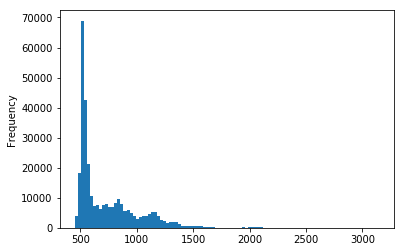

In [121]:
print("Min: {}, max: {}, mu: {}, std: {}".format(
df["result"].min(), df["result"].max(), df["result"].mean(), df["result"].std()))
df["result"].plot.hist(bins=100)
plt.show()

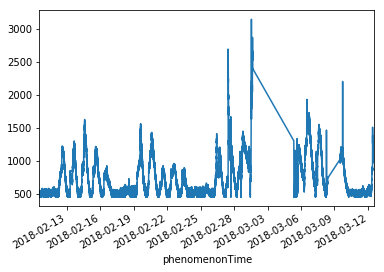

In [122]:
# Timeline for the dataframe
df["result"].plot()
plt.show()

# Create a new Index from the Notebook

In [123]:
doc = {
    'author': 'kimchy',
    'text': 'Elasticsearch: cool. bonsai cool.',
    'timestamp': datetime.datetime.now(),
}
res = es.index(index="test-index", doc_type='tweet', id=1, body=doc)
#print(res['created'])

PUT http://elasticsearch:9200/test-index/tweet/1 [status:404 request:0.002s]


NotFoundError: TransportError(404, 'index_not_found_exception', "no such index and [action.auto_create_index] ([.security,.monitoring*,.watches,.triggered_watches,.watcher-history*,logstash*]) doesn't match")

In [124]:
# the version iterates over the data
es.get(index="test-index", doc_type='tweet', id=1)

GET http://elasticsearch:9200/test-index/tweet/1 [status:404 request:0.004s]


NotFoundError: TransportError(404, 'index_not_found_exception', 'no such index')

In [133]:
es.indices.refresh(index="test-index*")

{'_shards': {'failed': 0, 'successful': 5, 'total': 10}}

# Connector to Spark

In [125]:
df.head(3)

,name,result
phenomenonTime,,
2018-02-27 15:43:35,Airquality DS,1122
2018-02-27 15:44:09,Airquality DS,1104
2018-02-27 15:44:42,Airquality DS,1114


In [126]:
import pyspark
sc = pyspark.SparkContext.getOrCreate()
sc


<SparkContext master=local[*] appName=pyspark-shell>

In [127]:
# create pyspark-dataFrame
sqlCtx = pyspark.SQLContext(sc)
sdf = sqlCtx.createDataFrame(df.astype(str))
sdf.show(5)

+-------------+------+
|         name|result|
+-------------+------+
|Airquality DS|  1122|
|Airquality DS|  1104|
|Airquality DS|  1114|
|Airquality DS|  1097|
|Airquality DS|  1091|
+-------------+------+
only showing top 5 rows



In [112]:
sdf.rdd.first()  # ["host"]

Row(result='1122')

In [135]:
sdf.createOrReplaceTempView("tempTable")
res = sqlCtx.sql("""SELECT name, stddev(result) as std__of_result
            FROM tempTable
            GROUP BY name""")
res.show()

+-------------+-----------------+
|         name|   std__of_result|
+-------------+-----------------+
|Airquality DS|285.0924703064902|
+-------------+-----------------+



# Reading in Spark directly from Elasticsearch


In [137]:
import elasticsearch

In [138]:
help(elasticsearch)

Help on package elasticsearch:

NAME
    elasticsearch

PACKAGE CONTENTS
    client (package)
    compat
    connection (package)
    connection_pool
    exceptions
    helpers (package)
    serializer
    transport

DATA
    VERSION = (6, 1, 1)
    __versionstr__ = '6.1.1'
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...

VERSION
    (6, 1, 1)

FILE
    /opt/conda/lib/python3.6/site-packages/elasticsearch/__init__.py




In [139]:
df = sqlCtx.read.format("es")


In [140]:
!echo $PYSPARK_PYTHON

/opt/conda/bin/python


In [141]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Sniffing

In [142]:
from elasticsearch import Elasticsearch

# you can specify to sniff on startup to inspect the cluster and load
# balance across all nodes
# you can also sniff periodically and/or after failure:
es = Elasticsearch([{'host': 'elasticsearch', 'port': 9200}],
          sniff_on_start=True,
          sniff_on_connection_fail=True,
          sniffer_timeout=60)